In [1]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from utils.fourier_base import compute_fourier_base

from vecopsciml.operators.zero_order import Mx, My

In [3]:
from architectures.pgnniv_baseline import PGNNIVBaseline
from architectures.pgnniv_fourier import PGNNIVFourier
from architectures.pgnniv_pod import PGNNIVPOD
from architectures.pgnniv_decoder import PGNNIVAutoencoder
from architectures.autoencoder import Autoencoder

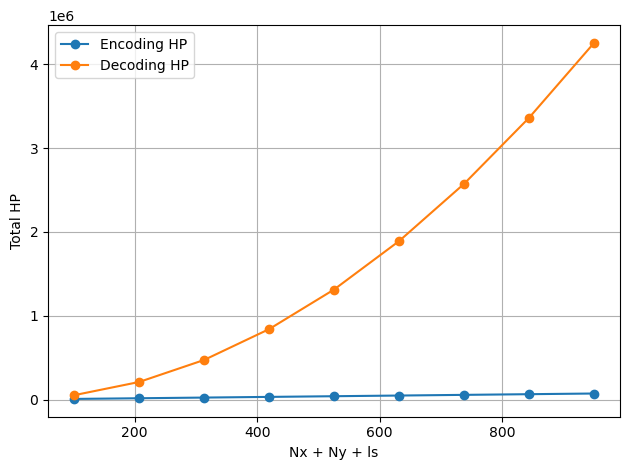

In [15]:
# Define a range of values for Nx + Ny and ls (total hyperparameters)
Nx_Ny_range = np.arange(100, 1000, 100)  # Total of Nx + Ny from 10 to 200
ls_values = np.linspace(1, 50, len(Nx_Ny_range))  # Smoothly varying ls values for demonstration

# Initialize lists to store results
HP_encoding = []
HP_decoding = []
HP_total = []
HP_sum = []

# Compute HP values
for Nx_Ny, ls in zip(Nx_Ny_range, ls_values):
    Nx = Ny = Nx_Ny // 2  # Split evenly for plotting purposes
    encoding = 80 * Nx_Ny + 230 + 11 * ls
    decoding = 230 + 10 * ls + 21 * Nx * Ny
    HP_encoding.append(encoding)
    HP_decoding.append(decoding)
    HP_total.append(encoding + decoding)
    HP_sum.append(Nx_Ny + ls)

# Plotting
# plt.figure(figsize=(10, 6))
plt.plot(HP_sum, HP_encoding, label="Encoding HP", marker='o')
plt.plot(HP_sum, HP_decoding, label="Decoding HP", marker='o')
plt.xlabel("Nx + Ny + ls")
plt.ylabel("Total HP")
# plt.title("Comparison of HP_encoding and HP_decoding evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
